<a href="https://colab.research.google.com/github/farkoo/Cat-Dog-Classifier/blob/master/CatDogClassifier_Part_2_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare train and test data (Data Preprocessing)

In [ ]:
%%bash
git clone "https://github.com/MKasaei00/IUT-CI-HW3-cat-dog-classifier.git"

Cloning into 'IUT-CI-HW3-cat-dog-classifier'...


In [ ]:
%cd IUT-CI-HW3-cat-dog-classifier

/content/IUT-CI-HW3-cat-dog-classifier


In [ ]:
%%bash
7z x dataset/test_set.zip -odataset
7z x dataset/training_set.zip -odataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 3711630 bytes (3625 KiB)

Extracting archive: dataset/test_set.zip
--
Path = dataset/test_set.zip
Type = zip
Physical Size = 3711630
Embedded Stub Size = 4
Total Physical Size = 45654670
Multivolume = +
Volume Index = 2
Volumes = 3

Everything is Ok

Folders: 3
Files: 2000
Size:       45739128
Compressed: 45654670

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 13986903 bytes (14 MiB)

Extracting archive: dataset/training_set.zip
--
Path = dataset/training_set.zip
Type = zip
Physical Size = 13986903
Embedded Stub Size = 4
Total Physical Size = 181759063
Multivolum

In [ ]:
import numpy as np
import os
import cv2
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [ ]:
test_dir = 'dataset/test_set'
training_dir = 'dataset/training_set'

In [ ]:
def load_data_from_directory(dir,width,height,classes):
  img_data = []
  img_label = []
  categories = os.listdir(dir)
  for category in categories:
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      img = cv2.resize(img,(width,height))
      img = np.array(img).astype('float32') / 255
      
      img_data.append(img)
      img_label.append(category)

  img_onehot = np_utils.to_categorical([categories.index(label) for label in img_label],classes,dtype=np.ubyte)
  img_data = np.array(img_data)
  img_onehot = np.array(img_onehot)

  zip_list = list(zip(img_data, img_label, img_onehot))
  random.shuffle(zip_list)
  img_data, img_label, img_onehot = zip(*zip_list)
  return img_data , img_label, img_onehot

In [ ]:
classes = 2
w = 128
h = 128

In [ ]:
train_x , train_label, train_onehot = load_data_from_directory(training_dir,w,h,classes)
test_x , test_label, test_onehot = load_data_from_directory(test_dir,w,h,classes)

In [ ]:
test_label2 = []
for i, label in enumerate(test_label):
     test_label2.append(1) if (label == 'dogs') else test_label2.append(0)

In [ ]:
train_x = np.asarray(train_x)
train_label = np.asarray(train_label)
train_onehot = np.asarray(train_onehot)

test_x = np.asarray(test_x)
test_label = np.asarray(test_label2)
test_onehot = np.asarray(test_onehot)

In [ ]:
!rm -rf cleanData
!mkdir cleanData
np.save('cleanData/train_x.npy',train_x)
np.save('cleanData/train_label.npy',train_label)
np.save('cleanData/train_onehot.npy',train_onehot)

np.save('cleanData/test_x.npy',test_x)
np.save('cleanData/test_label.npy',test_label)
np.save('cleanData/test_onehot.npy',test_onehot)

In [ ]:
train_x = np.load('cleanData/train_x.npy')
train_label = np.load('cleanData/train_onehot.npy')

test_x = np.load('cleanData/test_x.npy')
test_label = np.load('cleanData/test_onehot.npy')
test_vec = np.load('cleanData/test_label.npy')

In [ ]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Label, valid_Label = train_test_split(train_x, train_label, test_size = 0.2, random_state = 13)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,LeakyReLU
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.initializers import RandomNormal
import math

<div dir='rtl'>
 تابع زیر مشابه همان تابع استفاده شده در قسمت الف است و از بهترین پارامترها و آخرین تستی که در قسمت قبل انجام شد استفاده می‌شود.

در این بخش قصد داریم با ثابت نگه‌داشتن تمام پارامترهای قبلی مانند دراپ‌اوت و آگمنتیشن و ... فقط تعداد داده‌های موجود در 
mini-batch 
را تغییر دهیم و نتایج را بررسی کنیم.

مشابه قسمت قبلی بعد از آموزش مدل روی داده‌های تست ارزیابی می‌شود و عملکرد کلی نمایش داده می‌شود.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  train_datagen = ImageDataGenerator(
        rotation_range=config['aug_rotation'],
        width_shift_range=config['aug_shift_w'],
        height_shift_range=config['aug_shift_h'],
        shear_range=config['aug_shear'],
        zoom_range=config['aug_zoom'],
        horizontal_flip=config['aug_horizontal_flip'],
        fill_mode='nearest'
  )

  train_generator = train_datagen.flow(train_X, train_Label, batch_size = config['batch'])

  validation_datagen = ImageDataGenerator()
  validation_generator = validation_datagen.flow(valid_X,valid_Label,batch_size=256)

  history = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs = config['epochs'],
                      batch_size=config['batch'],
                      steps_per_epoch=math.ceil(8000/config['batch']),
                      validation_steps = math.ceil(2000/config['batch'])
                    )
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)
  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])
  print('\n\n')
  
  predictes_classes = model.predict(test_x)
  predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

  from sklearn.metrics import classification_report
  target_names = ["Class {}".format(i) for i in range(classes)]
  print(classification_report(test_vec, predicted_classes, target_names = target_names))

  return model

<div dir='rtl'>
 همان ابرپارامترهای قسمت قبل را قرار می‌دهیم.

In [ ]:
base_config = {
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
}

# قسمت ب : بررسی اندازه دسته‌ها

<div dir='rtl'>

در تست‌های زیر همان داده‌ها را با اندازه‌ی بسته‌هایی که در زیر آمده است آموزش می‌دهیم.
+ 16
+ 64
+ 256
+ 512
+ 1000

</div>

Epoch 1/100
500/500 [==============================] - 55s 76ms/step - loss: 0.6967 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5095
Epoch 2/100
500/500 [==============================] - 36s 72ms/step - loss: 0.6933 - accuracy: 0.5049 - val_loss: 0.6933 - val_accuracy: 0.4906
Epoch 3/100
500/500 [==============================] - 36s 72ms/step - loss: 0.6938 - accuracy: 0.5093 - val_loss: 0.6930 - val_accuracy: 0.5094
Epoch 4/100
500/500 [==============================] - 36s 72ms/step - loss: 0.6933 - accuracy: 0.5016 - val_loss: 0.6921 - val_accuracy: 0.5326
Epoch 5/100
500/500 [==============================] - 36s 72ms/step - loss: 0.6932 - accuracy: 0.5140 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 6/100
500/500 [==============================] - 36s 73ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.4906
Epoch 7/100
500/500 [==============================] - 36s 72ms/step - loss: 0.6933 - accuracy: 0.4913 - val_loss: 0.6931 - val_ac

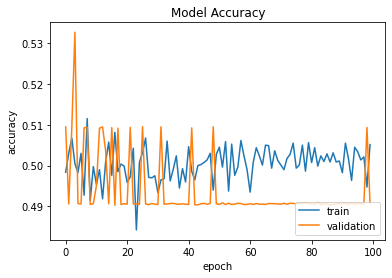

Test loss:  0.6931645274162292
Test accuracy:  0.5



              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      1000
     Class 1       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
config = dict(base_config)
config['batch'] = 16
model = train_model(config)

Epoch 1/100
125/125 [==============================] - 30s 217ms/step - loss: 0.6976 - accuracy: 0.4910 - val_loss: 0.6933 - val_accuracy: 0.5092
Epoch 2/100
125/125 [==============================] - 26s 208ms/step - loss: 0.6936 - accuracy: 0.4972 - val_loss: 0.6941 - val_accuracy: 0.4884
Epoch 3/100
125/125 [==============================] - 26s 207ms/step - loss: 0.6934 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.4918
Epoch 4/100
125/125 [==============================] - 26s 207ms/step - loss: 0.6932 - accuracy: 0.5062 - val_loss: 0.6889 - val_accuracy: 0.5612
Epoch 5/100
125/125 [==============================] - 27s 214ms/step - loss: 0.6931 - accuracy: 0.5284 - val_loss: 0.6929 - val_accuracy: 0.4976
Epoch 6/100
125/125 [==============================] - 26s 206ms/step - loss: 0.6932 - accuracy: 0.5159 - val_loss: 0.6939 - val_accuracy: 0.4895
Epoch 7/100
125/125 [==============================] - 26s 207ms/step - loss: 0.6938 - accuracy: 0.4933 - val_loss: 0.6944 -

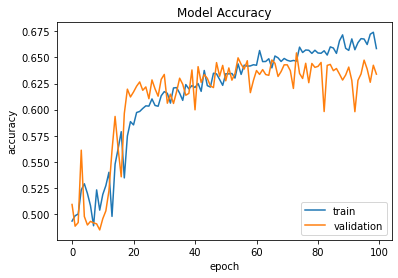

Test loss:  0.6265059113502502
Test accuracy:  0.640999972820282



              precision    recall  f1-score   support

     Class 0       0.67      0.55      0.61      1000
     Class 1       0.62      0.73      0.67      1000

    accuracy                           0.64      2000
   macro avg       0.65      0.64      0.64      2000
weighted avg       0.65      0.64      0.64      2000



In [ ]:
config = dict(base_config)
config['batch'] = 64
model = train_model(config)

Epoch 1/100
32/32 [==============================] - 28s 794ms/step - loss: 0.6960 - accuracy: 0.4897 - val_loss: 0.6931 - val_accuracy: 0.5081
Epoch 2/100
32/32 [==============================] - 23s 738ms/step - loss: 0.6941 - accuracy: 0.4970 - val_loss: 0.6930 - val_accuracy: 0.5043
Epoch 3/100
32/32 [==============================] - 23s 742ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6926 - val_accuracy: 0.5210
Epoch 4/100
32/32 [==============================] - 24s 745ms/step - loss: 0.6926 - accuracy: 0.5294 - val_loss: 0.6929 - val_accuracy: 0.5090
Epoch 5/100
32/32 [==============================] - 23s 739ms/step - loss: 0.6934 - accuracy: 0.4924 - val_loss: 0.6922 - val_accuracy: 0.5065
Epoch 6/100
32/32 [==============================] - 24s 747ms/step - loss: 0.6933 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.4784
Epoch 7/100
32/32 [==============================] - 23s 742ms/step - loss: 0.6937 - accuracy: 0.5045 - val_loss: 0.6928 - val_accuracy:

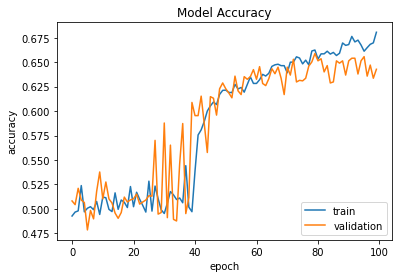

Test loss:  0.6176678538322449
Test accuracy:  0.6614999771118164



              precision    recall  f1-score   support

     Class 0       0.64      0.75      0.69      1000
     Class 1       0.70      0.57      0.63      1000

    accuracy                           0.66      2000
   macro avg       0.67      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000



In [ ]:
config = dict(base_config)
config['batch'] = 256
model = train_model(config)

Epoch 1/100
16/16 [==============================] - 26s 1s/step - loss: 0.6946 - accuracy: 0.4994 - val_loss: 0.6930 - val_accuracy: 0.5146
Epoch 2/100
16/16 [==============================] - 22s 1s/step - loss: 0.6950 - accuracy: 0.4931 - val_loss: 0.6930 - val_accuracy: 0.5108
Epoch 3/100
16/16 [==============================] - 22s 1s/step - loss: 0.6936 - accuracy: 0.5065 - val_loss: 0.6929 - val_accuracy: 0.5361
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 0.6935 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 5/100
16/16 [==============================] - 21s 1s/step - loss: 0.6934 - accuracy: 0.5077 - val_loss: 0.6908 - val_accuracy: 0.4988
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 0.6923 - accuracy: 0.5258 - val_loss: 0.6933 - val_accuracy: 0.5084
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 0.6878 - accuracy: 0.5628 - val_loss: 0.6793 - val_accuracy: 0.5830
Epoch 8/100
1

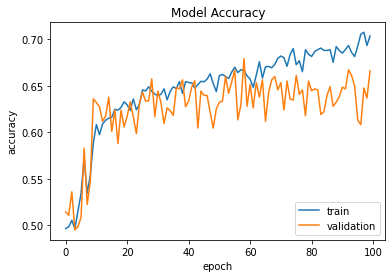

Test loss:  0.6474739909172058
Test accuracy:  0.6545000076293945



              precision    recall  f1-score   support

     Class 0       0.67      0.60      0.64      1000
     Class 1       0.64      0.70      0.67      1000

    accuracy                           0.65      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.66      0.65      0.65      2000



In [ ]:
config = dict(base_config)
config['batch'] = 512
model = train_model(config)

Epoch 1/100
8/8 [==============================] - 23s 3s/step - loss: 0.6935 - accuracy: 0.5061 - val_loss: 0.7130 - val_accuracy: 0.4707
Epoch 2/100
8/8 [==============================] - 20s 3s/step - loss: 0.6992 - accuracy: 0.5048 - val_loss: 0.6935 - val_accuracy: 0.4707
Epoch 3/100
8/8 [==============================] - 20s 3s/step - loss: 0.6938 - accuracy: 0.4953 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 4/100
8/8 [==============================] - 20s 3s/step - loss: 0.6937 - accuracy: 0.4949 - val_loss: 0.6969 - val_accuracy: 0.4902
Epoch 5/100
8/8 [==============================] - 20s 3s/step - loss: 0.6946 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.5094
Epoch 6/100
8/8 [==============================] - 20s 3s/step - loss: 0.6936 - accuracy: 0.4836 - val_loss: 0.6956 - val_accuracy: 0.4453
Epoch 7/100
8/8 [==============================] - 19s 3s/step - loss: 0.6928 - accuracy: 0.5092 - val_loss: 0.6926 - val_accuracy: 0.5703
Epoch 8/100
8/8 [==========

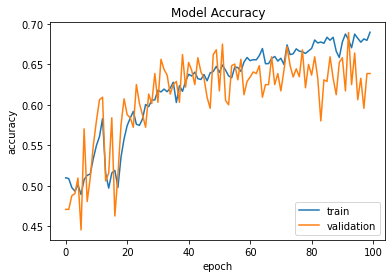

Test loss:  0.6220986843109131
Test accuracy:  0.6600000262260437



              precision    recall  f1-score   support

     Class 0       0.65      0.69      0.67      1000
     Class 1       0.67      0.63      0.65      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



In [ ]:
config = dict(base_config)
config['batch'] = 1000
model = train_model(config)

# تحلیل تغییر اندازه‌ی دسته‌ها

<div dir='rtl'>

از نظر زمانی که برای آموزش دادن مدل در هر 
epoch 
نیاز است. هر چه تعداد نمونه در دسته بیش‌تر شود به معنای استفاده‌ی بهتر از امکانات و کارایی پردازش‌هایی برداری و موازی است و می‌توان با استفاده از کارت گرافیک سرعت بالاتری را تجربه کرد.

به طور کلی وقتی اندازه‌ی دسته کوچک می‌شود و پس از بررسی هر دسته وزن‌های موجود در شبکه بروز می‌شوند و با توجه به پراکندگی نمونه‌ها در مجموعه‌ی داده‌های آموزشی وزن‌های شبکه بسیار محلی و به صورت نوسانی تغییر می‌کنند.
تا حدی که با توجه به تست اول که با دسته‌های ۱۶ تایی انجام شد در عمل به دلیل نوسان های توضیح داده شده یادگیری انجام نشد و دقت در مجموعه‌ی آموزشی و تست حدود همان ۵۰ درصد است که به معنای عدم یادگیری شبکه است.

در دسته‌های بزرگ‌تر علاوه‌ بر سرعت بیش‌تر پردازش در حین آموزش مدل در نهایت مسیر همگرایی هموار‌تر است و با سرعت بیش‌تری به دقت‌های بالا همگرا می‌شود.

مسئله‌ای که در شبکه‌های عصبی مطرح است بحث مقداردهی اولیه است. در شبکه‌های عصبی مقداردهی اولیه در آموزش دیدن شبکه مهم است و در صورتی که از دسته با تعداد داده‌ی زیاد استفاده کنیم پاسخ نهایی وابستگی زیادی به مقداردهی اولیه خواهد داشت ولی اگر دسته‌ها کوچک باشند و با توجه به پراکندگی داده‌های اموزشی می‌توان در برخی نقاط حالت نوسانی ایجاد شود که کمک می‌کند از یک حداقل محلی در تابع هزینه جدا شویم و به قسمت‌های دیگر همگرا شود.

پس درنهایت برای استفاده از امکانات پردازش موازی و سرعت آموزش بالا و نوسان و تغییر به حالت‌های بدتر برای نجات از حداقل‌های محلی لازم است اندازه ی بسته‌ها متوسط انتخاب شود که در این مثال مقدار 256 مناسب است و انتخاب شده است.